# Network Intrusion Detection Using Machine Learning/Deep Learning
This notebook involves the making of machine learning & deep learning models to classify the given data of obtained as a network intrusion into different classes (malignant or benign). Given a sample point, the objective of machine learning model will be to classify that whether the intrusion made is  **Benign** or is a **Malignant** (classify into its specific type).

In [1]:
# ========== STANDARD LIBRARIES ==========
import os
import time
import numpy as np
import pandas as pd

# ========== VISUALIZATION ==========
import matplotlib.pyplot as plt
import seaborn as sns

# ========== SCIKIT-LEARN (Machine Learning) ==========
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.feature_selection import VarianceThreshold, SelectKBest, f_classif
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix
)
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# ========== TENSORFLOW / KERAS (Deep Learning) ==========
import tensorflow as tf
from tensorflow.keras import Model, Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv1D, MaxPooling1D, BatchNormalization, Dropout, Dense, Flatten,
    Bidirectional, LSTM, GlobalAveragePooling1D, MultiHeadAttention
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (
    CSVLogger, EarlyStopping, ReduceLROnPlateau, TerminateOnNaN
)
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
print("ok")

2026-01-02 14:15:24.064140: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1767363324.219981      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1767363324.267923      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

ok


# Check CPU status

In [2]:
from cpuinfo import get_cpu_info

cpu_info = get_cpu_info()
print("CPU Hardware on Kaggle")
print(f"Brand: {cpu_info['brand_raw']}")
print(f"Architecture: {cpu_info['arch']}")
print(f"Cores (Physical): {cpu_info['count']}")
print(f"Threads (Logical): {cpu_info['count'] * 2 if 'ht' in cpu_info['flags'] else cpu_info['count']}")
print(f"Clock Speed: {cpu_info['hz_advertised_friendly']}")
print(f"Flags (Features): {cpu_info['flags'][:10]}...")  # Shows first 10 CPU features

CPU Hardware on Kaggle
Brand: Intel(R) Xeon(R) CPU @ 2.00GHz
Architecture: X86_64
Cores (Physical): 4
Threads (Logical): 8
Clock Speed: 2.0000 GHz
Flags (Features): ['3dnowprefetch', 'abm', 'adx', 'aes', 'apic', 'arat', 'arch_capabilities', 'avx', 'avx2', 'avx512bw']...


# Check GPU status
In this project I use GPU P100 to accelerate training speed

In [3]:
# Verify GPU availability
gpus = tf.config.list_physical_devices('GPU')
print(f"Available GPUs: {gpus}")

Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
!nvidia-smi

Fri Jan  2 14:15:39 2026       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.172.08             Driver Version: 570.172.08     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   33C    P0             25W /  250W |       3MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Load data from IDS-CIC_IDS2018 dataset
- clean the data and sample from it to create new smaller and balance dataset

In [5]:
# check the available data
file_paths = []
for root, dirs, filenames in os.walk('/kaggle/input/ids-intrusion-csv'):
    for filename in filenames:
        file_paths.append(os.path.join(root, filename))
        
# Remove specific file if needed
file_paths.remove('/kaggle/input/ids-intrusion-csv/02-20-2018.csv') # this file is 4.05GB with different shape from the others
print("Number of input files:", len(file_paths))

Number of input files: 9


## Clean the data and sample from it to create new smaller and balance dataset
- load all data from file paths (this may cause crash due to RAM overflow)
- randomly take 41500 samples from the raw data
- encode ['Label'] column to numeric value
- delete rows which contain inf or non-numeric value
- randomly take 40000 samples from the cleaned data (from top 9 value_counts)
- save to csv file for later use (optional)

In [6]:
def load_data(file_paths):
    combined_df = pd.DataFrame()
    for file in file_paths:
        print("Loading:", file)
        data = pd.read_csv(file, low_memory=False)
        
        # Combine with other files
        combined_df = pd.concat([combined_df, data], ignore_index=True, copy=False)

    return combined_df.drop(columns=["Timestamp"]) # remove Timestamp because it's irrelevant to the result
df = load_data(file_paths)
print(df['Label'].value_counts())

target_values = ['DoS attacks-Slowloris', 'DDOS attack-LOIC-UDP', 'Brute Force -Web', 'Brute Force -XSS', 'SQL Injection', 'Label'] # these targets have too few samples (Label is an error from concatenate data)
df = df[~df['Label'].isin(target_values)]
df = df.groupby('Label', group_keys=False).sample(n=41500, random_state=42)

def clean_data(data):
    encoder = LabelEncoder()
    data['Label'] = encoder.fit_transform(data['Label']) # encode Label (string to number from 0 to 8)
    data = data.apply(pd.to_numeric, errors='coerce') # if error (meet non-numeric value), turn that value into np.nan
    data = data.replace([np.inf, -np.inf], np.nan) # replace inf value (or extreme value) to np.nan
    data = data.dropna()
    return pd.DataFrame(data), encoder
df, encoder = clean_data(df)
df = df.groupby('Label', group_keys=False).sample(n=40000, random_state=42)
# df = pd.DataFrame(df)

print(df['Label'].unique())
print(df['Label'].value_counts())

# Save to output directory
df.to_csv('/kaggle/working/cleaned_data_sampled.csv', index=False)

Loading: /kaggle/input/ids-intrusion-csv/02-28-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/03-01-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-16-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-15-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-21-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/03-02-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-22-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-14-2018.csv
Loading: /kaggle/input/ids-intrusion-csv/02-23-2018.csv
Label
Benign                      6112151
DDOS attack-HOIC             686012
DoS attacks-Hulk             461912
Bot                          286191
FTP-BruteForce               193360
SSH-Bruteforce               187589
Infilteration                161934
DoS attacks-SlowHTTPTest     139890
DoS attacks-GoldenEye         41508
DoS attacks-Slowloris         10990
DDOS attack-LOIC-UDP           1730
Brute Force -Web                611
Brute Force -XSS                230
SQL Injection         

In [7]:
print("Label encoder mapping:")
for i, label in enumerate(encoder.classes_):
    print(f"{i}: {label}")

Label encoder mapping:
0: Benign
1: Bot
2: DDOS attack-HOIC
3: DoS attacks-GoldenEye
4: DoS attacks-Hulk
5: DoS attacks-SlowHTTPTest
6: FTP-BruteForce
7: Infilteration
8: SSH-Bruteforce


# Preprocess data for training
This preprocessing pipeline performs:

- Split features and labels
→ separates Label from the other columns.

- Train/test split with stratification
→ keeps the same class distribution in both sets.

- Avoids data leakage
→ feature selection and scaling are fitted only on training data, then applied to test.

- Variance-based feature selection
→ removes features that carry little or no information.

- Robust scaling
→ scales features using robust statistics (less sensitive to outliers).

- One-hot encode labels
→ converts class IDs into vectors for neural networks.

- Reshape inputs for deep learning
→ transforms data to (samples, features, 1) for CNN/LSTM models.
- Returns two formats at once:
   + 2D → for classical ML (LogReg, RF, etc.)
   + 3D + one-hot → for CNN / BiLSTM / Attention.

In [8]:
def preprocess_and_split(data, test_size=0.2, random_state=42):
    # 1) Separate features (X) and labels (y)
    X = data.drop('Label', axis=1)
    y = data['Label']      # labels are already numeric (encoded earlier)

    # 2) Split into train/test BEFORE fitting selector & scaler (to avoid leakage)
    X_train, X_test, y_train_ml, y_test_ml = train_test_split(
        X, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # 3) Fit feature selector & scaler ONLY on training data,
    #    then transform both train and test
    selector = VarianceThreshold(threshold=0.01)
    X_train_filtered = selector.fit_transform(X_train)
    X_test_filtered  = selector.transform(X_test)

    scaler = RobustScaler(quantile_range=(5, 95))
    X_train_ml = scaler.fit_transform(X_train_filtered)
    X_test_ml  = scaler.transform(X_test_filtered)

    # 4) Prepare labels for CNN (one-hot encoding)
    num_classes = int(y.nunique())
    y_train_cnn = to_categorical(y_train_ml, num_classes=num_classes)
    y_test_cnn  = to_categorical(y_test_ml,  num_classes=num_classes)

    # 5) Reshape to 3D for CNN/LSTM: (N, n_features, 1)
    X_train_cnn = X_train_ml[..., np.newaxis]
    X_test_cnn  = X_test_ml[...,  np.newaxis]

    return (
        X_train_ml, X_test_ml, y_train_ml, y_test_ml,       # 2D for classical ML
        X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn    # 3D + one-hot for deep learning
    )


(
    X_train, X_test, y_train_ml, y_test_ml,
    X_train_cnn, X_test_cnn, y_train_cnn, y_test_cnn
) = preprocess_and_split(df, test_size=0.2, random_state=42)

print("\nFinal dataset shapes:")
print(f"X_train (ML 2D): {X_train.shape}, y_train_ml: {y_train_ml.shape}")
print(f"X_test  (ML 2D): {X_test.shape},  y_test_ml:  {y_test_ml.shape}")
print(f"X_train_cnn (3D): {X_train_cnn.shape}, y_train_cnn: {y_train_cnn.shape}")
print(f"X_test_cnn  (3D): {X_test_cnn.shape},  y_test_cnn:  {y_test_cnn.shape}")


Final dataset shapes:
X_train (ML 2D): (288000, 67), y_train_ml: (288000,)
X_test  (ML 2D): (72000, 67),  y_test_ml:  (72000,)
X_train_cnn (3D): (288000, 67, 1), y_train_cnn: (288000, 9)
X_test_cnn  (3D): (72000, 67, 1),  y_test_cnn:  (72000, 9)


## CNN + BiLSTM + Attention Model 

Build a deep neural network that:

- Uses CNN to learn local patterns from features

- Uses BiLSTM to capture temporal dependencies in both directions

- Uses Multi-Head Self-Attention to focus on important time steps

- Outputs multiclass probabilities with a softmax layer

In [9]:
num_classes = y_train_cnn.shape[1]
timesteps = X_train_cnn.shape[1]   # number of features after selector/scaler
channels  = X_train_cnn.shape[2]   # = 1 (univariate channel)

inputs = Input(shape=(timesteps, channels), name="inputs")

# --- CNN feature extractor ---
x = Conv1D(
    128, 3,
    activation='relu',
    padding='same',
    kernel_regularizer=l2(1e-3)
)(inputs)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

x = Conv1D(
    256, 3,
    activation='relu',
    padding='same',
    kernel_regularizer=l2(1e-3)
)(x)
x = BatchNormalization()(x)
x = MaxPooling1D(2, padding='same')(x)
x = Dropout(0.3)(x)

# --- BiLSTM (keep full sequence for attention) ---
x = Bidirectional(
    LSTM(128, return_sequences=True),
    name="bilstm"
)(x)

# --- Multi-Head Self-Attention ---
attn_out = MultiHeadAttention(
    num_heads=4,
    key_dim=64,
    name="mha"
)(x, x)
x = x + attn_out          # residual connection
x = BatchNormalization()(x)

# --- Temporal pooling (aggregate information over time after attention) ---
x = GlobalAveragePooling1D(name="gap")(x)

# --- Classifier head ---
x = Dense(
    128,
    activation='relu',
    kernel_regularizer=l2(1e-3)
)(x)
x = Dropout(0.3)(x)
outputs = Dense(
    num_classes,
    activation='softmax',
    name="softmax"
)(x)

attn_model = Model(inputs, outputs, name="CNN_BiLSTM_Attn")
attn_model.summary()

I0000 00:00:1767363660.606468      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "CNN_BiLSTM_Attn"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 67, 1)     │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d (Conv1D)     │ (None, 67, 128)   │        512 │ inputs[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 67, 128)   │        512 │ conv1d[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d       │ (None, 34, 128)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 34, 128)   │          0 │ max_pooling1d[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_1 (Conv1D)   │ (None, 34, 256)   │     98,560 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 34, 256)   │      1,024 │ conv1d_1[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling1d_1     │ (None, 17, 256)   │          0 │ batch_normalizat… │
│ (MaxPooling1D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 17, 256)   │          0 │ max_pooling1d_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 17, 256)   │    394,240 │ dropout_1[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mha                 │ (None, 17, 256)   │    263,168 │ bilstm[0][0],     │
│ (MultiHeadAttentio… │                   │            │ bilstm[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 17, 256)   │          0 │ bilstm[0][0],     │
│                     │                   │            │ mha[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 17, 256)   │      1,024 │ add[0][0]         │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gap                 │ (None, 256)       │          0 │ batch_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ gap[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax (Dense)     │ (None, 9)         │      1,161 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 793,097 (3.03 MB)

 Trainable params: 791,817 (3.02 MB)

 Non-trainable params: 1,280 (5.00 KB)

### Create TensorFlow dataset for CNN model

In [10]:
batch_size = 256
train_dataset = tf.data.Dataset.from_tensor_slices((X_train_cnn, y_train_cnn))
train_dataset = train_dataset.shuffle(buffer_size=len(X_train_cnn))
train_dataset = train_dataset.batch(batch_size)
train_dataset = train_dataset.prefetch(tf.data.AUTOTUNE)

### Sanity check: Print sample model output before training (prevent error)

In [11]:
try:
    sample_batch = next(iter(train_dataset))[0]  # Get one batch from training set
    output = cnn_model(sample_batch, training=False)
    print("Sample model output before training:")
    print(output.numpy())
except Exception as e:
    print("Error generating model output before training:", str(e))

Error generating model output before training: name 'cnn_model' is not defined


## Machine Learning model
- SGDClassifier
- Logistic Regression
- GaussianNB
- Decision Tree
- Random Forest

In [12]:
ml_models = {
    # 1. SGDClassifier
    "SGD": make_pipeline(
        SelectKBest(f_classif, k=30),
        SGDClassifier(
            loss='modified_huber',
            penalty='l2',
            max_iter=1000,
            tol=1e-3,
            n_jobs=-1,
            early_stopping=True,
            random_state=42
        )
    ),
    
    # 2. Logistic Regression
    "LogReg": make_pipeline(
        SelectKBest(f_classif, k=30),
        LogisticRegression(
            solver='saga',
            multi_class='multinomial',
            max_iter=500,
            n_jobs=-1,
            random_state=42
        )
    ),
    
    # 3. GaussianNB
    "NaiveBayes": make_pipeline(
        SelectKBest(f_classif, k=30),
        GaussianNB()
    ),
    
    # 4. Decision Tree
    "DecisionTree": make_pipeline(
        SelectKBest(f_classif, k=30),
        DecisionTreeClassifier(
            max_depth=10,
            min_samples_split=50,
            ccp_alpha=0.01,
            random_state=42
        )
    ),
    
    # 5. Random Forest
    "RandomForest": make_pipeline(
        SelectKBest(f_classif, k=30),
        RandomForestClassifier(
            n_estimators=50,
            max_depth=10,
            n_jobs=-1,
            random_state=42
        )
    )
}

# Model training

In [13]:
# Callbacks
lr = 1e-4
optimizer = Adam(learning_rate=lr)
attn_model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy', tf.keras.metrics.Precision(name='Precision'),
             tf.keras.metrics.Recall(name='Recall')]
)

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6),
    tf.keras.callbacks.TerminateOnNaN()
]


# Training
start_time = time.time()
with tf.device('/GPU:0'):
    print("Training CNN+BiLSTM+Attention...")
    history_attn = attn_model.fit(
        train_dataset,
        epochs=50,
        validation_data=(X_test_cnn, y_test_cnn),
        callbacks=callbacks,
        verbose=1
    )
training_time = time.time()-start_time

print(f"Model trained in {training_time:.2f} seconds")

Training CNN+BiLSTM+Attention...
Epoch 1/50


I0000 00:00:1767363668.758018     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


1125/1125 ━━━━━━━━━━━━━━━━━━━━ 45s 33ms/step - Precision: 0.6757 - Recall: 0.4450 - accuracy: 0.5762 - loss: 1.3596 - val_Precision: 0.7661 - val_Recall: 0.7134 - val_accuracy: 0.7522 - val_loss: 0.7305 - learning_rate: 1.0000e-04
Epoch 2/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - Precision: 0.8127 - Recall: 0.7877 - accuracy: 0.8023 - loss: 0.6361 - val_Precision: 0.8410 - val_Recall: 0.8372 - val_accuracy: 0.8391 - val_loss: 0.5444 - learning_rate: 1.0000e-04
Epoch 3/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - Precision: 0.8457 - Recall: 0.8377 - accuracy: 0.8420 - loss: 0.4948 - val_Precision: 0.8524 - val_Recall: 0.8499 - val_accuracy: 0.8514 - val_loss: 0.4351 - learning_rate: 1.0000e-04
Epoch 4/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 37s 32ms/step - Precision: 0.8541 - Recall: 0.8495 - accuracy: 0.8521 - loss: 0.4179 - val_Precision: 0.8554 - val_Recall: 0.8543 - val_accuracy: 0.8547 - val_loss: 0.3714 - learning_rate: 1.0000e-04
Epoch 5/50
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 3

In [14]:
def train_model(model, X_train, y_train):
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    print(f"Model trained in {training_time:.2f} seconds\n")
    return model

history_ml = {}
training_times = {}
for name, model in ml_models.items():
    print(f"Training {name}!!!")
    start_time = time.time()
    history_ml[name] = train_model(model, X_train, y_train_ml)
    training_times[name] = time.time() - start_time

Training SGD!!!
Model trained in 2.90 seconds

Training LogReg!!!


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Model trained in 296.64 seconds

Training NaiveBayes!!!
Model trained in 0.56 seconds

Training DecisionTree!!!
Model trained in 1.82 seconds

Training RandomForest!!!
Model trained in 5.08 seconds



# Evaluation & visualization

- **Generates predictions** for the test set using the trained CNN+BiLSTM+Attention model.
- **Converts probabilities to class labels** by taking the argmax over the softmax outputs.
- **Computes standard metrics** (Accuracy, Precision, Recall, F1-score) with weighted averaging for multiclass classification.
- **Builds a confusion matrix** to inspect which classes are correctly or incorrectly classified.
- **Visualizes the confusion matrix** as a heatmap with class names on both axes.
- **Plots training curves** (accuracy and loss over epochs) for both training and validation sets.
- **Clears the Keras backend** after plotting to free GPU/CPU memory for further experiments.


Evaluating model...
Prediction output shape: (72000, 9)

=== Evaluation Metrics ===
Accuracy : 0.8741 (87.41%)
Precision: 0.8845 (88.45%)
Recall   : 0.8741 (87.41%)
F1-Score : 0.8709 (87.09%)


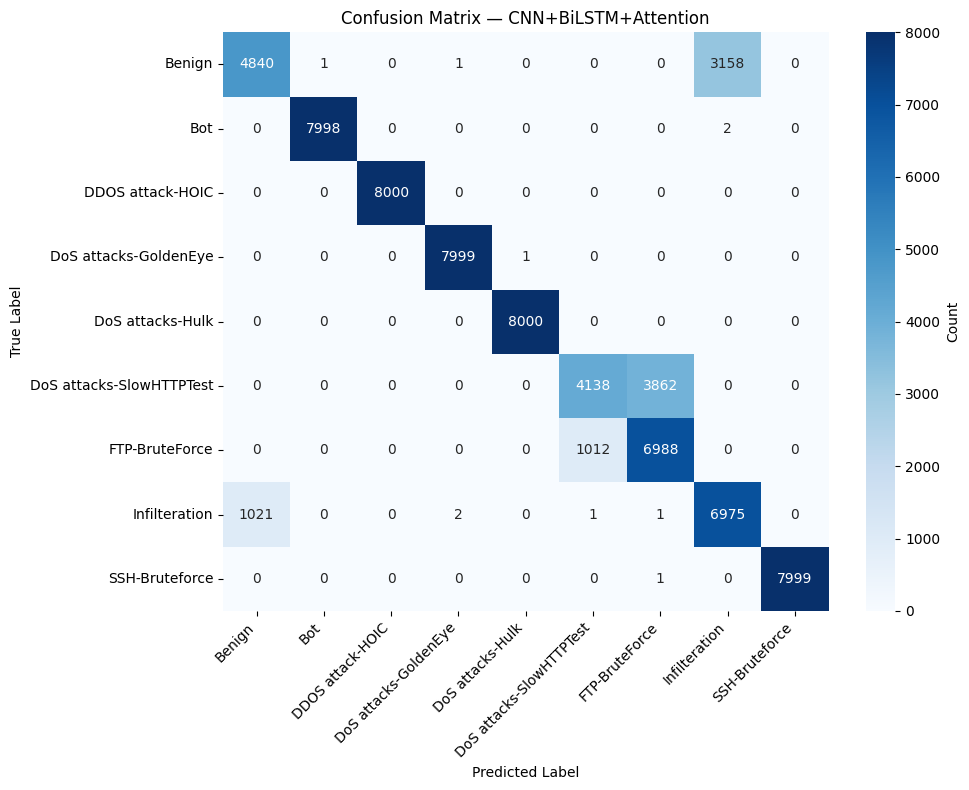

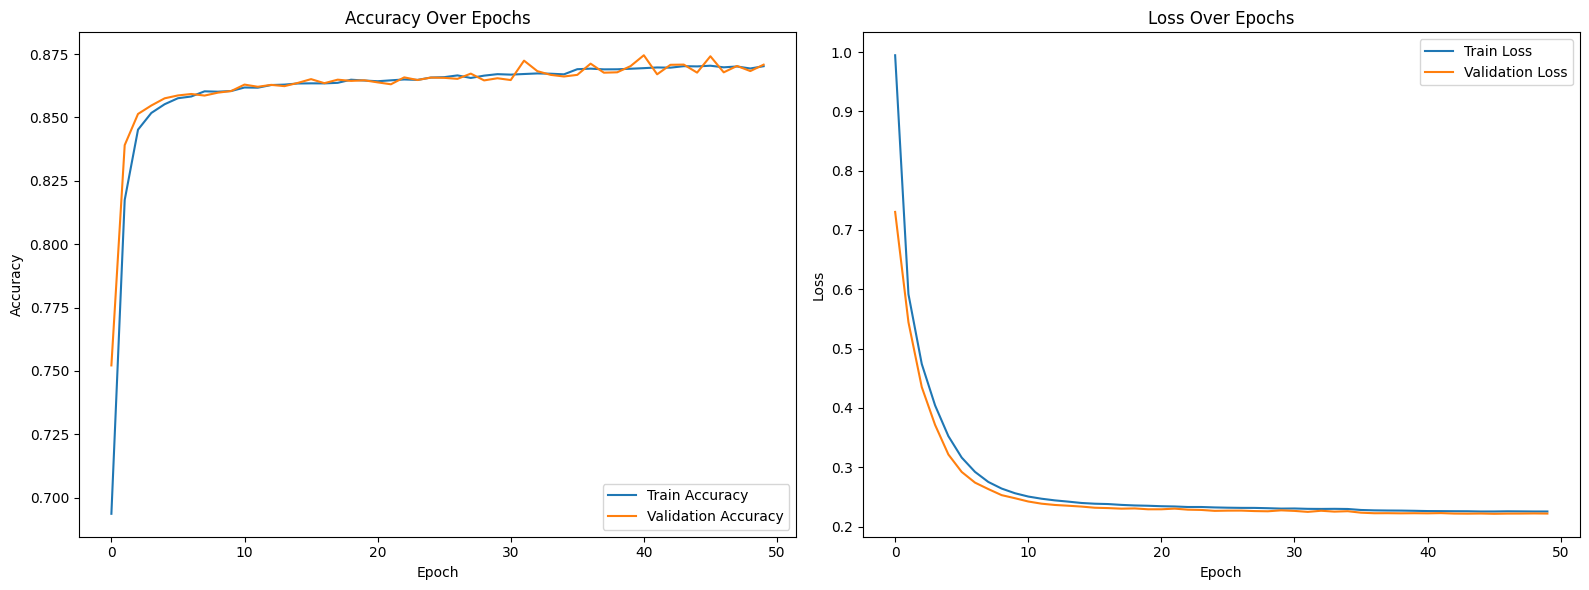

In [15]:
print("\nEvaluating model...")

# === Dự đoán lớp và xác suất ===
y_pred_probs = attn_model.predict(X_test_cnn, verbose=0)
print("Prediction output shape:", y_pred_probs.shape)

# Lấy lớp dự đoán và lớp thật
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cnn, axis=1)

# === Tính các chỉ số đánh giá ===
acc  = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred, average='weighted', zero_division=0)

print("\n=== Evaluation Metrics ===")
print(f"Accuracy : {acc:.4f} ({acc*100:.2f}%)")
print(f"Precision: {prec:.4f} ({prec*100:.2f}%)")
print(f"Recall   : {rec:.4f} ({rec*100:.2f}%)")
print(f"F1-Score : {f1:.4f} ({f1*100:.2f}%)")

# === Confusion Matrix ===
labels = list(encoder.classes_)  # encoder đã dùng khi encode y
cm = confusion_matrix(y_true, y_pred, labels=range(len(labels)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels,
            cbar_kws={'label': 'Count'})
plt.title("Confusion Matrix — CNN+BiLSTM+Attention")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# === Hàm vẽ biểu đồ training history ===
def plot_history(history):
    plt.figure(figsize=(16, 6))

    # Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# === Vẽ lịch sử huấn luyện của mô hình Attention ===
plot_history(history_attn)

# === Dọn bộ nhớ Keras ===
tf.keras.backend.clear_session()

=== Evaluation Phase ===

📊 SGD Evaluation:
----------------------
Accuracy: 0.7825
Precision (weighted): 0.8132
Recall (weighted): 0.7825
F1-Score (weighted): 0.7684

Classification Report:
              precision    recall  f1-score   support

           0       0.61      0.45      0.52      8000
           1       0.88      0.98      0.93      8000
           2       0.99      1.00      1.00      8000
           3       0.95      0.66      0.78      8000
           4       0.74      0.97      0.84      8000
           5       0.60      0.99      0.75      8000
           6       0.97      0.33      0.50      8000
           7       0.58      0.65      0.61      8000
           8       0.99      1.00      1.00      8000

    accuracy                           0.78     72000
   macro avg       0.81      0.78      0.77     72000
weighted avg       0.81      0.78      0.77     72000



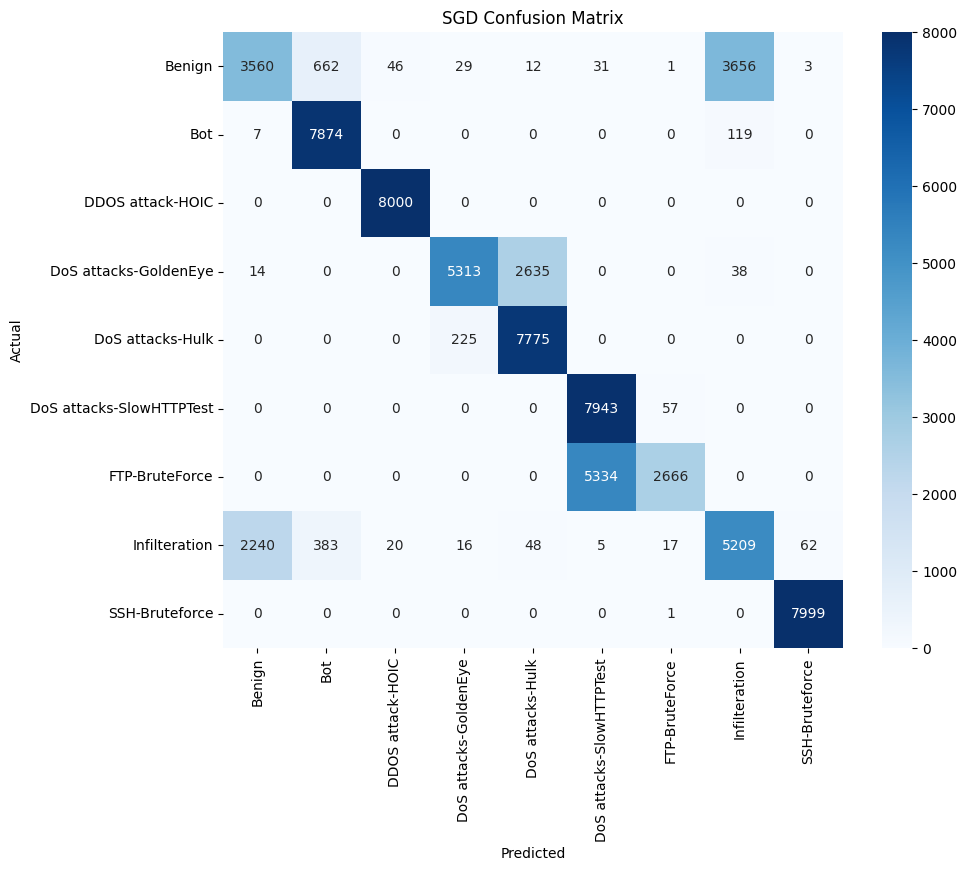


📊 LogReg Evaluation:
----------------------
Accuracy: 0.7927
Precision (weighted): 0.8033
Recall (weighted): 0.7927
F1-Score (weighted): 0.7847

Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.43      0.55      8000
           1       0.82      0.99      0.90      8000
           2       0.99      1.00      0.99      8000
           3       0.95      0.67      0.79      8000
           4       0.74      0.97      0.84      8000
           5       0.71      0.55      0.62      8000
           6       0.63      0.78      0.70      8000
           7       0.62      0.74      0.67      8000
           8       0.99      1.00      1.00      8000

    accuracy                           0.79     72000
   macro avg       0.80      0.79      0.78     72000
weighted avg       0.80      0.79      0.78     72000



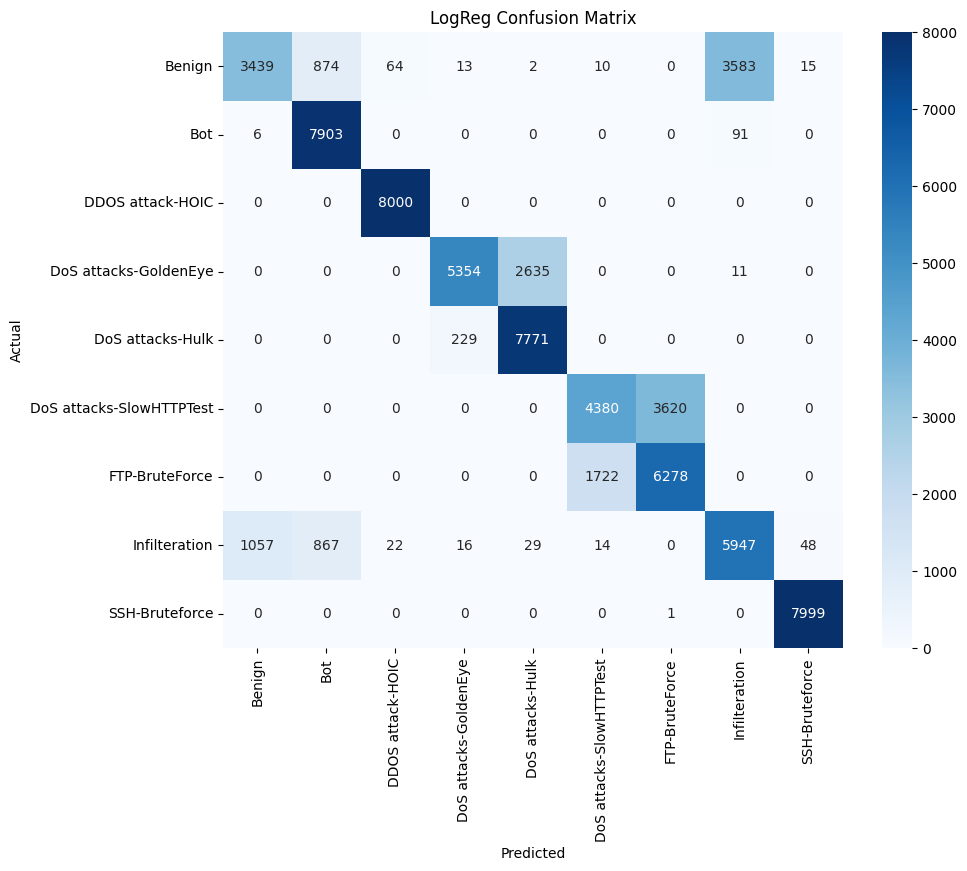


📊 NaiveBayes Evaluation:
----------------------
Accuracy: 0.7064
Precision (weighted): 0.7405
Recall (weighted): 0.7064
F1-Score (weighted): 0.6860

Classification Report:
              precision    recall  f1-score   support

           0       0.63      0.41      0.50      8000
           1       0.78      0.99      0.87      8000
           2       0.86      1.00      0.93      8000
           3       0.56      0.67      0.61      8000
           4       0.74      0.95      0.83      8000
           5       0.60      0.99      0.75      8000
           6       0.98      0.33      0.50      8000
           7       0.57      0.52      0.54      8000
           8       0.96      0.50      0.65      8000

    accuracy                           0.71     72000
   macro avg       0.74      0.71      0.69     72000
weighted avg       0.74      0.71      0.69     72000



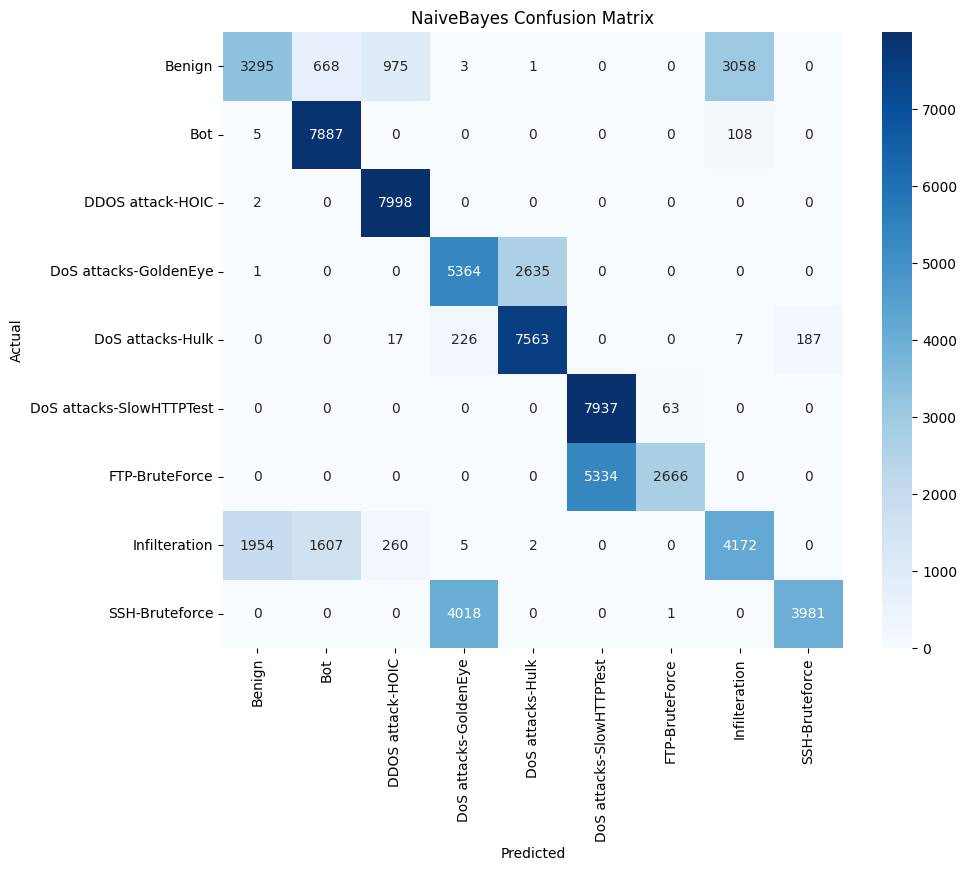


📊 DecisionTree Evaluation:
----------------------
Accuracy: 0.8155
Precision (weighted): 0.8756
Recall (weighted): 0.8155
F1-Score (weighted): 0.7888

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.18      0.29      8000
           1       1.00      0.99      0.99      8000
           2       1.00      1.00      1.00      8000
           3       0.97      0.94      0.96      8000
           4       0.94      0.97      0.96      8000
           5       0.59      0.99      0.74      8000
           6       0.98      0.33      0.50      8000
           7       0.53      0.94      0.68      8000
           8       0.96      1.00      0.98      8000

    accuracy                           0.82     72000
   macro avg       0.88      0.82      0.79     72000
weighted avg       0.88      0.82      0.79     72000



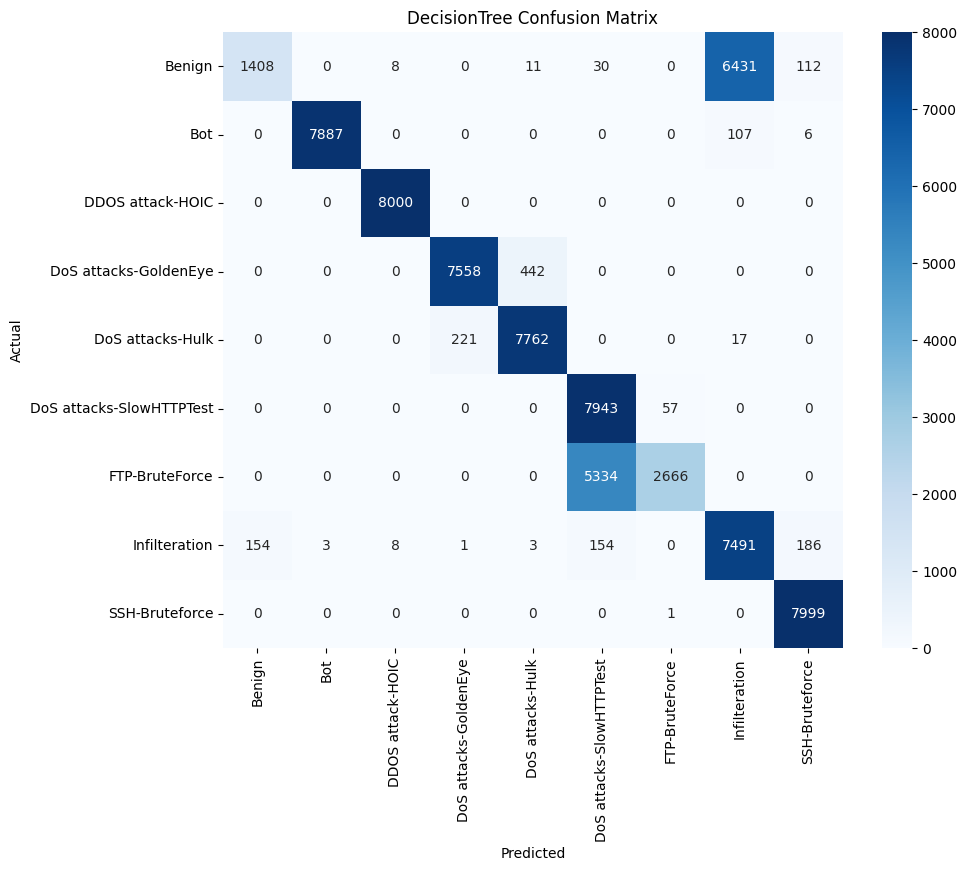


📊 RandomForest Evaluation:
----------------------
Accuracy: 0.8796
Precision (weighted): 0.8908
Recall (weighted): 0.8796
F1-Score (weighted): 0.8764

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.63      0.72      8000
           1       1.00      1.00      1.00      8000
           2       1.00      1.00      1.00      8000
           3       1.00      1.00      1.00      8000
           4       1.00      1.00      1.00      8000
           5       0.82      0.52      0.64      8000
           6       0.65      0.88      0.75      8000
           7       0.70      0.89      0.79      8000
           8       1.00      1.00      1.00      8000

    accuracy                           0.88     72000
   macro avg       0.89      0.88      0.88     72000
weighted avg       0.89      0.88      0.88     72000



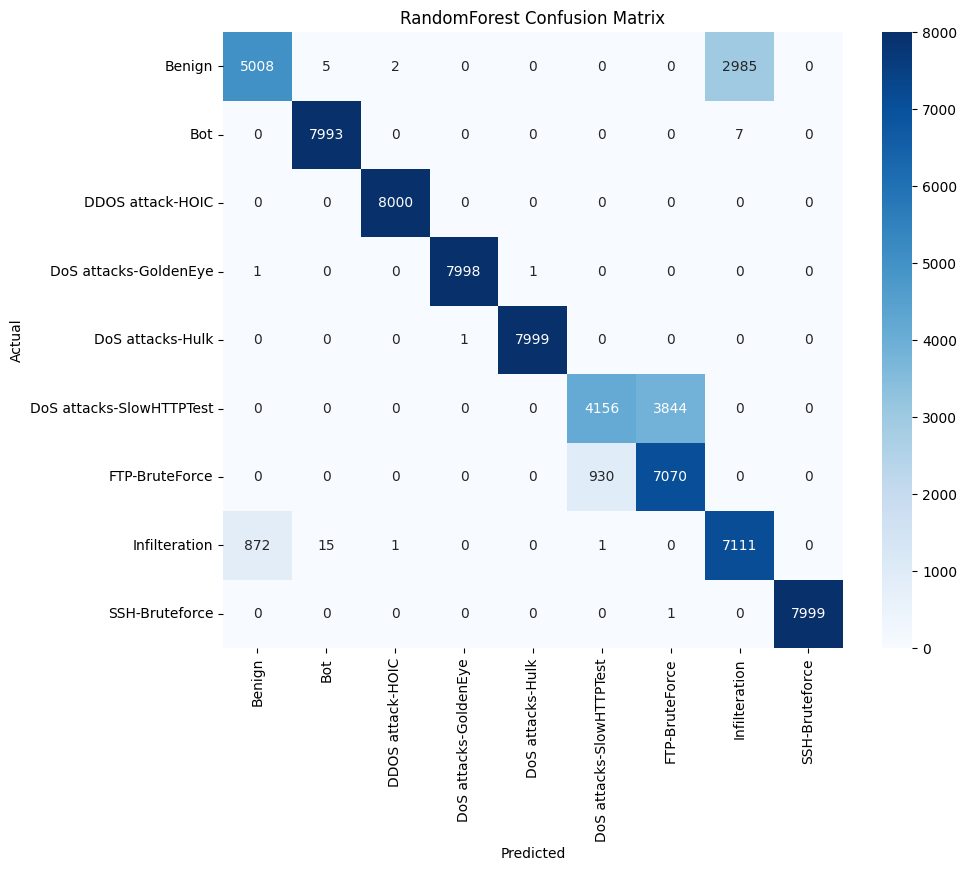

In [16]:
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    
    print(f"\n📊 {name} Evaluation:")
    print("----------------------")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Precision (weighted): {precision_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"Recall (weighted): {recall_score(y_test, y_pred, average='weighted'):.4f}")
    print(f"F1-Score (weighted): {f1_score(y_test, y_pred, average='weighted'):.4f}")
    
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(10,8))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels ,
                yticklabels=labels )
    plt.title(f'{name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

print("=== Evaluation Phase ===")
for name, model in history_ml.items():
    evaluate_model(model, X_test, y_test_ml, name)
    print("="*80)

Final Model Comparison:


,Model,Training Time (s),Accuracy,Precision,Recall,F1
0,SGD,2.898653,0.782486,0.813188,0.782486,0.768412
1,LogReg,296.642656,0.792653,0.803345,0.792653,0.784720
2,NaiveBayes,0.561435,0.706431,0.740505,0.706431,0.686029
3,DecisionTree,1.823726,0.815472,0.875611,0.815472,0.788848
4,RandomForest,5.082887,0.879639,0.890778,0.879639,0.876402


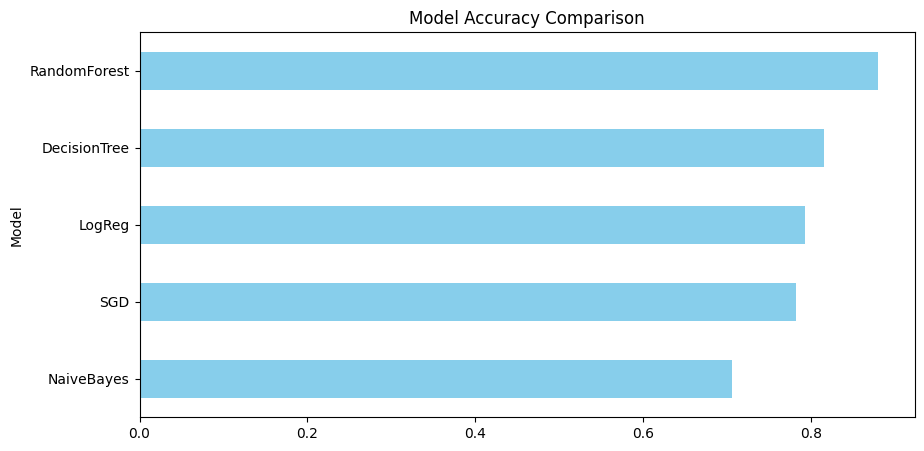

In [17]:
# Compile results
results = []
for name, model in history_ml.items():
    y_pred = model.predict(X_test)
    results.append({
        'Model': name,
        'Training Time (s)': training_times[name],
        'Accuracy': accuracy_score(y_test_ml, y_pred),
        'Precision': precision_score(y_test_ml, y_pred, average='weighted'),
        'Recall': recall_score(y_test_ml, y_pred, average='weighted'),
        'F1': f1_score(y_test_ml, y_pred, average='weighted')
    })

# Display as table
results_df = pd.DataFrame(results)
print("Final Model Comparison:")
display(results_df.style.background_gradient(cmap='YlGnBu', subset=['Accuracy', 'F1']))

# Visual comparison
plt.figure(figsize=(10,5))
results_df.set_index('Model')['Accuracy'].sort_values().plot(
    kind='barh', 
    title='Model Accuracy Comparison',
    color='skyblue'
)
plt.show()

# **FPR-Constrained Thresholding**
This method focuses on controlling the False Positive Rate (FPR) to maintain system stability and avoid unnecessary alerts. By analyzing the ROC curve, the threshold is chosen as the largest value that keeps the FPR below a predefined limit (e.g., 5%). This ensures that benign traffic is rarely misclassified as malicious, preventing alert fatigue and maintaining operational efficiency. The approach is particularly suitable for intrusion detection environments where excessive false alarms can overwhelm analysts and degrade the reliability of the IDS.

In [30]:
# Predict probabilities from the Attention model
y_pred_probs = attn_model.predict(X_test_cnn, verbose=0)

# True class indices (multiclass)
y_true = np.argmax(y_test_cnn, axis=1)

# Original string labels from LabelEncoder
labels = list(encoder.classes_)

# Index of "Benign" class
benign_idx = labels.index("Benign")

print("Benign index:", benign_idx)
print("Prediction shape:", y_pred_probs.shape)

Benign index: 0
Prediction shape: (72000, 9)


In [24]:
from sklearn.metrics import (roc_curve)

In [31]:
# --- Convert the task to binary: 1 = Benign, 0 = Attack ---
y_true_binary = (y_true == benign_idx).astype(int)

# ROC curve for the "Benign" probability
fpr, tpr, thresholds = roc_curve(y_true_binary, y_pred_probs[:, benign_idx])

# Target false positive rate (depends on security policy)
target_fpr = 0.06

# Choose the largest threshold such that FPR <= target_fpr
idx = np.where(fpr <= target_fpr)[0][-1]
chosen_threshold = thresholds[idx]

print("\n================= THRESHOLD SELECTION =================")
print("Chosen threshold:", chosen_threshold)
print("Benign TPR at threshold:", tpr[idx])
print("Benign FPR at threshold:", fpr[idx])


================= THRESHOLD SELECTION =================
Chosen threshold: 0.4138671
Benign TPR at threshold: 0.89475
Benign FPR at threshold: 0.059984375


In [32]:
# --- Apply the threshold to convert probabilities to final predictions ---
y_pred_thresh = []

for p in y_pred_probs:
    # If Benign probability is high enough → classify as Benign
    if p[benign_idx] >= chosen_threshold:
        y_pred_thresh.append(benign_idx)
    else:
        # Otherwise suppress Benign and choose the strongest attack class
        p2 = p.copy()
        p2[benign_idx] = -1
        y_pred_thresh.append(np.argmax(p2))

y_pred_thresh = np.array(y_pred_thresh)


================= METRICS AFTER THRESHOLD =================
Accuracy  : 0.8672
Precision : 0.8810
Recall    : 0.8672
F1-score  : 0.8626

================= CLASSIFICATION REPORT =================
                          precision    recall  f1-score   support

                  Benign       0.65      0.89      0.75      8000
                     Bot       1.00      1.00      1.00      8000
        DDOS attack-HOIC       1.00      1.00      1.00      8000
   DoS attacks-GoldenEye       1.00      1.00      1.00      8000
        DoS attacks-Hulk       1.00      1.00      1.00      8000
DoS attacks-SlowHTTPTest       0.80      0.52      0.63      8000
          FTP-BruteForce       0.64      0.87      0.74      8000
           Infilteration       0.83      0.52      0.64      8000
          SSH-Bruteforce       1.00      1.00      1.00      8000

                accuracy                           0.87     72000
               macro avg       0.88      0.87      0.86     72000
          

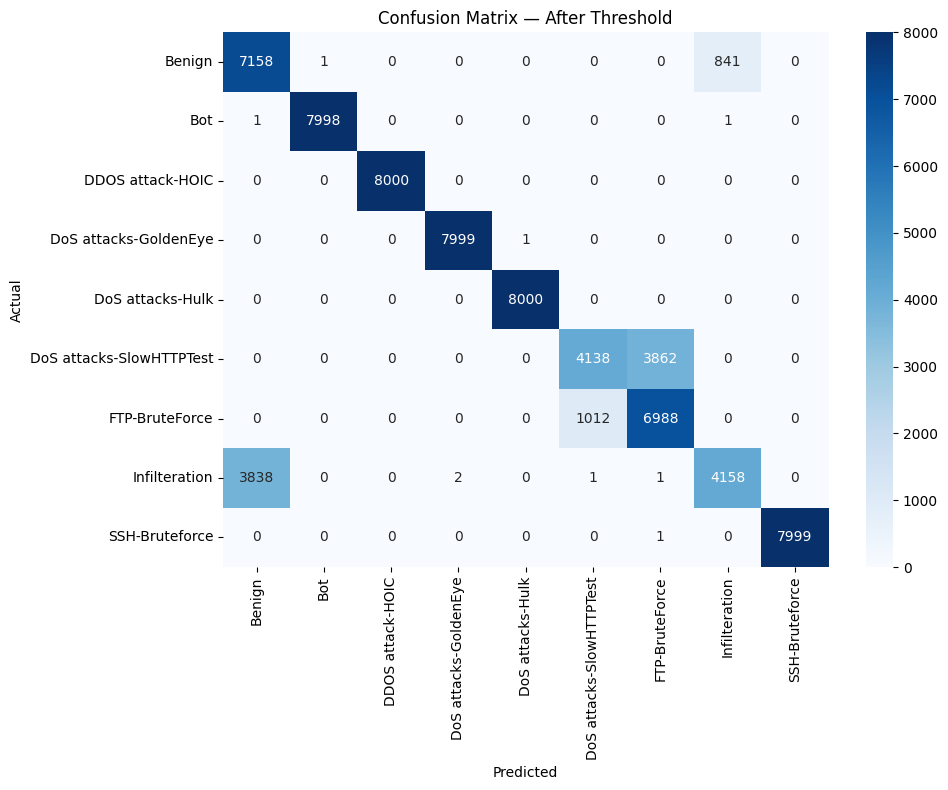

In [27]:
acc  = accuracy_score(y_true, y_pred_thresh)
prec = precision_score(y_true, y_pred_thresh, average='weighted', zero_division=0)
rec  = recall_score(y_true, y_pred_thresh, average='weighted', zero_division=0)
f1   = f1_score(y_true, y_pred_thresh, average='weighted', zero_division=0)

print("\n================= METRICS AFTER THRESHOLD =================")
print(f"Accuracy  : {acc:.4f}")
print(f"Precision : {prec:.4f}")
print(f"Recall    : {rec:.4f}")
print(f"F1-score  : {f1:.4f}")
print("\n================= CLASSIFICATION REPORT =================")
print(classification_report(y_true, y_pred_thresh, target_names=labels, zero_division=0))


# (BENIGN → ATTACK)
cm = confusion_matrix(y_true, y_pred_thresh)
print(cm)

benign_total = cm[benign_idx].sum()
benign_misclassified = benign_total - cm[benign_idx][benign_idx]

false_positive_rate = benign_misclassified / benign_total

print("\n================= FALSE POSITIVE RATE =================")
print(f"False Positive Rate (benign→attack): {false_positive_rate:.4f}")

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix — After Threshold")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# **DECISION THRESHOLD (Precision–Recall curve)**
This method focuses on ensuring high precision (e.g., ≥ 0.80) to minimize false alarms, while keeping recall as high as possible. The largest threshold meeting the precision target is selected. It is most suitable for intrusion detection scenarios where false positives can lead to excessive alerts and reduced system efficiency.”

In [28]:
labels = list(encoder.classes_)
print(labels)

benign_idx = labels.index("Benign")

X_test_df = pd.DataFrame(X_test, columns=[f"f{i}" for i in range(X_test.shape[1])])

y_true_idx = np.argmax(y_test_cnn, axis=1)
y_true_labels = [labels[i] for i in y_true_idx]

y_pred_labels = [labels[i] for i in y_pred]

prob_benign = y_pred_probs[:, benign_idx]

threshold_benign = chosen_threshold
print("Threshold Benign =", threshold_benign)

num_alert_samples = 100
sample_ids = np.random.choice(len(X_test), size=num_alert_samples, replace=False)


# TẠO DATAFRAME CẢNH BÁO
df_alert = X_test_df.iloc[sample_ids].copy()

df_alert.insert(0, "sample_id", sample_ids)
df_alert["true_label"] = [y_true_labels[i] for i in sample_ids]
df_alert["pred_label"] = [y_pred_labels[i] for i in sample_ids]
df_alert["prob_benign"] = prob_benign[sample_ids]

def classify_alert(pred_label, prob_benign, threshold):
    if pred_label != "Benign" and prob_benign < threshold:
        return "ATTACK"
    else:
        return "NORMAL"

df_alert["alert"] = [
    classify_alert(df_alert["pred_label"].iloc[i],
                   df_alert["prob_benign"].iloc[i],
                   threshold_benign)
    for i in range(len(df_alert))
]

pd.set_option('display.float_format', lambda x: '%.10f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', df_alert.shape[0])  
display(df_alert[["sample_id", "true_label", "pred_label", "prob_benign", "alert"]])

['Benign', 'Bot', 'DDOS attack-HOIC', 'DoS attacks-GoldenEye', 'DoS attacks-Hulk', 'DoS attacks-SlowHTTPTest', 'FTP-BruteForce', 'Infilteration', 'SSH-Bruteforce']
Threshold Benign = 0.4138671


,sample_id,true_label,pred_label,prob_benign,alert
8606,8606,FTP-BruteForce,FTP-BruteForce,0.0000027138,ATTACK
50296,50296,Benign,Infilteration,0.4033510983,ATTACK
13763,13763,SSH-Bruteforce,SSH-Bruteforce,0.0000025237,ATTACK
42098,42098,DoS attacks-GoldenEye,DoS attacks-GoldenEye,0.0000026453,ATTACK
43185,43185,SSH-Bruteforce,SSH-Bruteforce,0.0000032827,ATTACK
63366,63366,FTP-BruteForce,FTP-BruteForce,0.0000027138,ATTACK
29209,29209,FTP-BruteForce,FTP-BruteForce,0.0000027138,ATTACK
44507,44507,DoS attacks-SlowHTTPTest,FTP-BruteForce,0.0000027138,ATTACK
10926,10926,DoS attacks-GoldenEye,DoS attacks-GoldenEye,0.0000004098,ATTACK
48318,48318,Benign,Benign,0.4689270258,NORMAL


# **ALERT TESTING**

In [33]:
import csv
from datetime import datetime
import time
import pytz
labels = list(encoder.classes_)
benign_idx = labels.index("Benign")
threshold_benign = chosen_threshold

def classify_alert(pred_label, prob_benign, threshold):
    if pred_label != "Benign" and prob_benign < threshold:
        return "ATTACK"
    else:
        return "NORMAL"

X_test_np  = np.array(X_test_cnn) 

y_true_idx = np.argmax(y_test_cnn, axis=1)

idx_benign  = np.where(y_true_idx == labels.index("Benign"))[0]
idx_infil   = np.where(y_true_idx == labels.index("Infilteration"))[0]
idx_other   = np.where(~np.isin(
    y_true_idx, 
    [labels.index("Benign"), labels.index("Infilteration")]
))[0]

total_flows = 18        
prob = [0.7, 0.2, 0.1]  # Benign / Infilter / Other

scenario_choices = np.random.choice(
    ["benign", "infilter", "other"],
    size=total_flows,
    p=prob
)
print("Benign threshold:", threshold_benign)

for i in range(total_flows):

    vn_tz = pytz.timezone("Asia/Ho_Chi_Minh")
    now = datetime.now(vn_tz).strftime("[%H:%M:%S]")

    flow_type = scenario_choices[i]

    if flow_type == "benign":
        sample_id = np.random.choice(idx_benign)
    elif flow_type == "infilter":
        sample_id = np.random.choice(idx_infil)
    else:
        sample_id = np.random.choice(idx_other)

    # Lấy data flow
    X_flow = X_test_np[sample_id].reshape(1, X_test_np.shape[1], X_test_np.shape[2])
    true_label = labels[y_true_idx[sample_id]]

    # Dự đoán
    probs = attn_model.predict(X_flow, verbose=0)[0]
    pred_idx = np.argmax(probs)
    pred_label = labels[pred_idx]
    prob_benign = float(probs[benign_idx])

    alert = classify_alert(pred_label, prob_benign, threshold_benign)

    # In lên console
    print(f"{now} FLOW {i:3d} | True={true_label:13s} | Pred={pred_label:13s} "
          f"| ProbBenign={prob_benign:6.4f} | Alert={alert}")

    if alert == "ATTACK":
        print("⚠️ Warming")
    time.sleep(10) 

Benign threshold: 0.4138671
[22:16:01] FLOW   0 | True=Benign        | Pred=Benign        | ProbBenign=0.9999 | Alert=NORMAL
[22:16:11] FLOW   1 | True=Benign        | Pred=Infilteration | ProbBenign=0.4500 | Alert=NORMAL
[22:16:21] FLOW   2 | True=Infilteration | Pred=Infilteration | ProbBenign=0.1765 | Alert=ATTACK
⚠️ Warming
[22:16:32] FLOW   3 | True=Benign        | Pred=Infilteration | ProbBenign=0.4997 | Alert=NORMAL
[22:16:42] FLOW   4 | True=Infilteration | Pred=Benign        | ProbBenign=0.6585 | Alert=NORMAL
[22:16:52] FLOW   5 | True=Benign        | Pred=Infilteration | ProbBenign=0.4793 | Alert=NORMAL
[22:17:02] FLOW   6 | True=Benign        | Pred=Benign        | ProbBenign=0.9126 | Alert=NORMAL
[22:17:12] FLOW   7 | True=Benign        | Pred=Infilteration | ProbBenign=0.4348 | Alert=NORMAL
[22:17:22] FLOW   8 | True=Benign        | Pred=Benign        | ProbBenign=0.9993 | Alert=NORMAL
[22:17:32] FLOW   9 | True=Infilteration | Pred=Infilteration | ProbBenign=0.0191 | Aler